# Land Use Supervised Classification (using Sentinel 2 Imagery) 

An analyst attempting to classify the features of an image, uses the elements of visual interpretation to identify homogeneous groups of pixels that represent interesting classes of surfaces. Digital image classification uses the spectral information contained in the values of one or more spectral bands to classify each pixel individually. This type of classification is called spectral clustering recognition. Both ways (manual or automatic) aim at assigning a particular class or theme (e.g. water, coniferous forest, corn, wheat, etc.) to each pixel in an image. The "new" image that represents the classification is composed of a mosaic of pixels that each belong to a particular theme. This image is essentially a thematic representation of the original image.

We will follow the following steps:

0. Preprocessing on Qgis

1. Import the necessary libraries

2. Import of the ground truth regions + Transformation + Split into Train/Test 

3. Training the model

4. Performance evaluation

5. Final result

6. Discussion

## Preprocessing on Qgis

After preparing the bands that are of interest to us (R, G, B, NIR), we create shapefiles that will be our AOIs (Areas Of Interest) with the help of a **true color visualization**. These AOIs will be used to create rasters to train our model and also to test it.

<img src="./img/Screenshot 2021-11-23 182245.png">

## Import the necessary libraries

The **modules** we will use are the following:

* **numpy**: NumPy is very useful for performing mathematical and logical operations on arrays. It provides an abundance of useful features for operations on n-arrays and matrices in Python ...

* **pandas**: pandas is a fast, powerful, flexible and easy to use open source data manipulation and analysis tool built on the Python programming language.

* **Matplotlib**: Matplotlib is a complete library for creating static, animated and interactive visualizations in Python. Matplotlib makes the easy things easy and the hard things possible.

* **Rasterio**: Geographic Information Systems use GeoTIFF and other formats to organize and store raster data sets, such as satellite images and terrain models. Rasterio reads and writes these formats and provides a Python API based on N-dimensional Numpy arrays and GeoJSON.

* **sklearn**: Scikit-learn is an open source machine learning library for the Python programming language. It provides a variety of classification, regression, and clustering algorithms, including support vector machines, random forests, gradient boosting, k-means, and DBSCAN, and is designed to interoperate with the NumPy and SciPy Python numerical and scientific libraries. Scikit-learn is a fiscally sponsored NumFOCUS project.

* **seaborn**: Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphs.

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns

## Import of the ground truth regions + Transformation + Split into Train/Test 

Concerning the known areas, they are extracted from the shapefiles created at the beginning, so for each class we will have the radiometric values of the 4 bands of these pixels assigned by the supervisor.

* Water **(0)**

In [2]:
wa_ = rasterio.open("./train-test-data/WATER_.tif")

# Read the image
array_wa = wa_.read()
# Creating numpy array
array_wa = np.array(array_wa)

water = pd.DataFrame(array_wa.reshape([4,-1]).T)
water = water[water[0] != 0]
water['target'] = 0

* Vegetation **(1)**

In [3]:
vegetation_ = rasterio.open("./train-test-data/VEGETATION_.tif")
array_vg = vegetation_.read()
array_vg = np.array(array_vg)
vegetation = pd.DataFrame(array_vg.reshape([4,-1]).T)
vegetation = vegetation[vegetation[0] != 0]
vegetation['target'] = 1

* Bare land **(2)**

In [4]:
bareland_ = rasterio.open("./train-test-data/BARELAND_.tif")
array_bl = bareland_.read()
array_bl = np.array(array_bl)
bareland = pd.DataFrame(array_bl.reshape([4,-1]).T)
bareland = bareland[bareland[0] != 0]
bareland['target'] = 2

* Urban **(3)**

In [5]:
urban_ = rasterio.open("./train-test-data/URBAN_.tif")
array_ur = urban_.read()
array_ur = np.array(array_ur)
urban = pd.DataFrame(array_ur.reshape([4,-1]).T)
urban = urban[urban[0] != 0]
urban['target'] = 3

In [6]:
frames = [water,vegetation, urban, bareland]

data = pd.concat(frames)

## Training the model

In [7]:
X = data.drop("target", axis=1)
y = data["target"]

# scaler = StandardScaler().fit(X)
# X_scaled = scaler.transform(X)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [8]:
# K-NNC
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

# Predict the labels of test data
knn_pred = knn.predict(X_test)

## Performance Evaluation

In [9]:
print(f"Accuracy (Precision): {accuracy_score(y_test, knn_pred)*100}")
print("-------------------------------------------")
print(classification_report(y_test, knn_pred))

Accuracy (Precision): 99.57370737073707
-------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8857
           1       0.99      1.00      0.99       640
           2       0.99      1.00      0.99      5542
           3       1.00      0.99      0.99      6777

    accuracy                           1.00     21816
   macro avg       0.99      1.00      0.99     21816
weighted avg       1.00      1.00      1.00     21816



(0) Water
(1) Vegetation
(2) Bareland
(3) Urban)


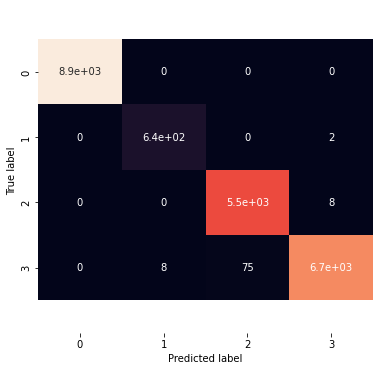

In [10]:
# Create a confusion matrix using the confusion_matrix function
confusion_matrix(y_test, knn_pred)
# Import seaborn for improving visualisation of confusion matrix

# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
    print("(0) Water\n(1) Vegetation\n(2) Bareland\n(3) Urban)")
    
plot_conf_mat(y_test, knn_pred)

**KAPPA SCORE**

In [11]:
cohen_kappa_score(y_test, knn_pred)

0.9936707987485184

## Final Result

In [12]:
src = rasterio.open('./train-test-data/4BANDS-SOURCE.tif')
array = src.read()
array = np.array(array)

sentinel2 = pd.DataFrame(array.reshape([4,-1]).T)

In [13]:
full = knn.predict(sentinel2)

In [14]:
full = full.reshape([1 ,3527, 2996])

In [15]:
profile = src.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open('./out/output.tif', 'w', **profile) as dst:
    dst.write(full.astype(rasterio.uint8))

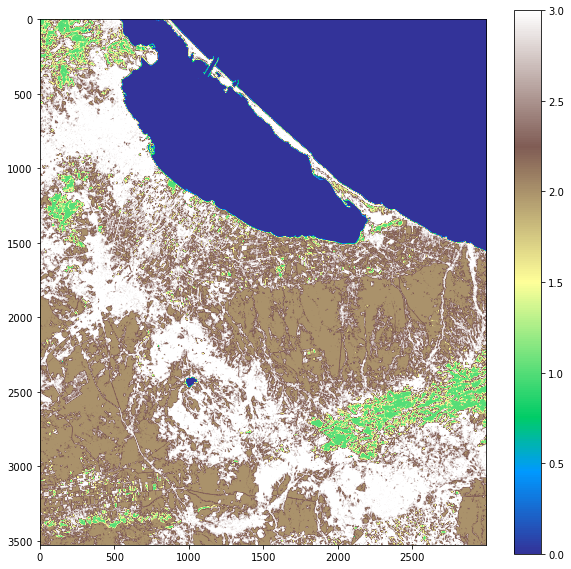

In [16]:
# open the raster
src=rasterio.open('./out/output.tif')

# display one band:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(src.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)

## Discussion

By seeing the classified output image it is clear that our algorithm :

* **has correctly classified all hydrography** **has missed some vegetation**

* **missed some vegetation areas** 

* **makes a big confusion between urban and bare ground**.

We are going to explore this below.

### Exploration of the best hyperparameters relative to the used KNN algorithm

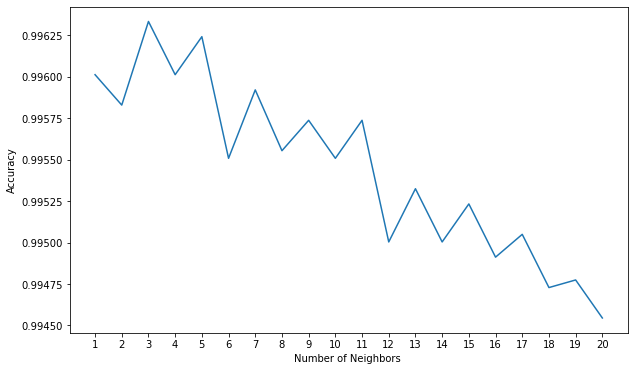

In [17]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mean_acc[i-1] = accuracy_score(y_test, yhat)
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [18]:
grid_params = { 'n_neighbors' : [1,3,4],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

# fit the model on our train set
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [19]:
# find the best score
g_res.best_score_

0.9962673380052602

In [20]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'}

In [21]:
# use the best hyperparameters
knn_ = KNeighborsClassifier(n_neighbors = 3, weights = 'distance',metric = 'minkowski')
knn_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [22]:
# get a prediction
y_hat = knn_.predict(X_train)
y_knn = knn_.predict(X_test)

Training set accuracy:  1.0
Test set accuracy:  0.9964246424642464
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8857
           1       0.99      1.00      0.99       640
           2       0.99      1.00      0.99      5542
           3       1.00      0.99      0.99      6777

    accuracy                           1.00     21816
   macro avg       0.99      1.00      1.00     21816
weighted avg       1.00      1.00      1.00     21816

Matrice de confusion:
(0) Water
(1) Vegetation
(2) Bareland
(3) Urban)
Model accuracy:  0.9914189055225402


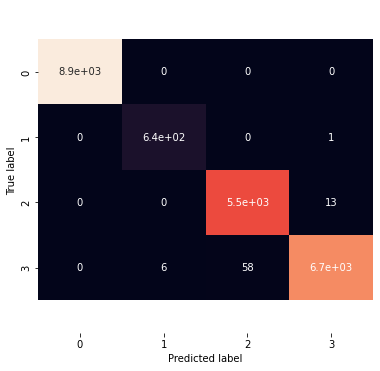

In [23]:
# Model Evaluation
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_knn))
print(classification_report(y_test, y_knn))
print("Matrice de confusion:")
plot_conf_mat(y_test, y_knn)
scores = cross_val_score(knn_, X, y, cv =5)
print('Model accuracy: ',np.mean(scores))

**KAPPA SCORE**

In [24]:
cohen_kappa_score(y_test, y_knn)

0.9946910860501694

**Final Result**

In [25]:
full_ = knn_.predict(sentinel2)

In [26]:
full_ = full_.reshape([1 ,3527, 2996])

In [27]:
profile = src.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open('./out/output_.tif', 'w', **profile) as dst:
    dst.write(full_.astype(rasterio.uint8))

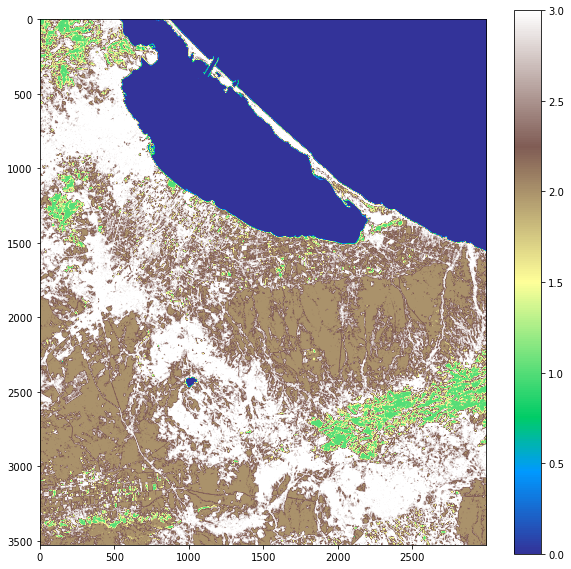

In [28]:
# open the raster
src=rasterio.open('./out/output_.tif')

# display one band:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(src.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)

Even with the optimal parameters on the training data the result is almost **the same** (See gif below).

<img src="./img/ezgif-3-478c20f5f241.gif">

### Exploration spectral signatures

As shown in the image below, there is an overlap between the spectral signature of the urban and the bare ground.
This explains the confusion between the urban and the bare ground.

<img src="./img/Screenshot 2021-11-23 182001.png">

The image below shows that there are areas of bare land but are assigned by our algorithm to the class of urban and this is due to the said overlap.

<img src="./img/Screenshot 2021-11-23 182107.png">

## Biblio/Webo-graphy

* https://scikit-learn.org/ (Documentation)
* https://numpy.org/ (Documentation)
* https://pandas.pydata.org/ (Documentation)
* https://seaborn.pydata.org/ (Documentation)
* https://matplotlib.org/ (Documentation)
* https://rasterio.readthedocs.io/en/latest/ 
* https://www.kaggle.com/arunimsamudra/k-nn-with-hyperparameter-tuning
* https://semiautomaticclassificationmanual-v5.readthedocs.io/en/latest/tutorial_2.html#id1
* https://www.researchgate.net/figure/Spectral-Signature-Example-of-spectral-signature-plot_fig17_277075873